In [289]:
# Libraries to load
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# data visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
pd.set_option('max_columns', None)
import pandas_profiling

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(123)

In [290]:
# Load DF
df = pd.read_csv('./data/cleaned_df.csv')

In [291]:
# Format Readmitted
df['readmitted'] = df.readmitted.map({'No':0,'Yes':1})

In [292]:
# Remove Expired or Hospice-bound Patients
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

# Dropping Features

In [293]:
#df = df.drop(columns = ["number_outpatient", "number_emergency", "acetohexamide", "tolbutamide", "miglitol", "troglitazone", "tolazamide",
       #"glipizide-metformin", "metformin-rosiglitazone", "metformin-pioglitazone", "examide", "citoglipton", "diabetesMed"])

#shortest drop list - no patients take these medications
df = df.drop(columns = ["examide", "citoglipton"])

# Feature Engineering

In [294]:
# Change medication to binary take vs not take - play with post model creation

medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for med in medication:
    df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

In [295]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age'] = df.age.replace(age_id)

In [296]:
# Inspect Unknown/Invalid results for Gender
df[df['gender'].str.contains('Unknown/Invalid')]

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
22926,Other,Unknown/Invalid,70,3,1,1,1,5,5,22,0,0,0,414,411,401,4,None,None,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Ch,Yes,0
55129,unknown,Unknown/Invalid,60,1,1,7,1,38,1,6,0,0,0,808,873,E813,5,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,0
59490,unknown,Unknown/Invalid,70,1,22,7,8,59,2,21,0,0,0,850,805,808,9,None,None,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Ch,Yes,0


In [297]:
# Only 3 values of unknown gender; drop those observations
df = df[df.gender != "Unknown/Invalid"]

In [298]:
# Create a function to group diagnostic codes by range as well as separating diabetes specifically

def diag_grouper(series):
    
    '''takes input as df.col and outputs diagnostic code groupings'''
    
    def no_str(x):
        
        '''takes input as an element of a series and pulls code for diabetes specific disease and E/V categories'''
        
        if '250' in x: return '9999'
        elif 'E' in x: return '123456'
        elif 'V' in x: return '123456'
        elif x == 'missing': return '-654321'
        else: return x
    
    series = series.apply(no_str)
    
    series = series.astype(float)
    
    def num_categ(x):
        
        '''takes input as an element of a series and saves each range as a numerical placeholder'''
        
        if 1 <= x <= 139: return 10000
        elif 140 <= x <= 239: return 10001
        elif 240 <= x <= 279: return 10002
        elif 280 <= x <= 289: return 10003
        elif 290 <= x <= 319: return 10004
        elif 320 <= x <= 389: return 10005
        elif 390 <= x <= 459: return 10006
        elif 460 <= x <= 519: return 10007
        elif 520 <= x <= 579: return 10008
        elif 580 <= x <= 629: return 10009
        elif 630 <= x <= 679: return 10010
        elif 680 <= x <= 709: return 10011
        elif 710 <= x <= 739: return 10012
        elif 740 <= x <= 759: return 10013
        elif 760 <= x <= 779: return 10014
        elif 780 <= x <= 799: return 10015
        elif 800 <= x <= 999: return 10016
        else: return x
        
    series = series.apply(num_categ)
    
    def text_convert(x):
        
        '''takes input as an element of a series and converts each placeholder to string format'''
        
        if x == 10000: return "Other"
        elif x == 10001: return "Other"
        elif x == 10002: return "Other"
        elif x == 10003: return "Other"
        elif x == 10004: return "Other"
        elif x == 10005: return "Other"
        elif x == 10006: return "Circulatory Disease"
        elif x == 10007: return "Respiratory Disease"
        elif x == 10008: return "Digestive Disease"
        elif x == 10009: return "Other"
        elif x == 10010: return "Other"
        elif x == 10011: return "Other"
        elif x == 10012: return "Other"
        elif x == 10013: return "Other"
        elif x == 10014: return "Other"
        elif x == 10015: return "Symptoms/Signs/Ill-Defined Conditions"
        elif x == 10016: return "Injury and Poisoning"
        elif x == 9999: return "Diabetes"
        elif x == 123456: return "Other"
        elif x == -654321: return "Other"
    
    return series.apply(text_convert)

In [299]:
# Apply diag_grouper to the data frame
df.diag_1 = diag_grouper(df.diag_1)
df.diag_2 = diag_grouper(df.diag_2)
df.diag_3 = diag_grouper(df.diag_3)

In [300]:
## Consolidating Diagnostic Codes Further
# Group Diagnostics By Top 7 Codes (using diag_1 as reference); all other codes as "Other"
df.groupby('diag_1')['diag_1'].count().sort_values(ascending=False)

#modifications to above function

diag_1
Circulatory Disease                      21315
Other                                    19941
Respiratory Disease                       6446
Digestive Disease                         6325
Diabetes                                  5748
Symptoms/Signs/Ill-Defined Conditions     5503
Injury and Poisoning                      4692
Name: diag_1, dtype: int64

In [301]:
# Create boolean masks for the columns in question

Circ = df[['diag_1','diag_2','diag_3']].isin(['Circulatory Disease']).astype(int)
Resp = df[['diag_1','diag_2','diag_3']].isin(['Respiratory Disease']).astype(int)
Digest = df[['diag_1','diag_2','diag_3']].isin(['Digestive Disease']).astype(int)
Diab = df[['diag_1','diag_2','diag_3']].isin(['Diabetes']).astype(int)
Symp = df[['diag_1','diag_2','diag_3']].isin(['Symptoms/Signs/Ill-Defined Conditions']).astype(int)
Inj = df[['diag_1','diag_2','diag_3']].isin(['Injury and Poisoning']).astype(int)
Othr = df[['diag_1','diag_2','diag_3']].isin(['Other']).astype(int)

In [302]:
Circulatory = (Circ['diag_1'] + Circ['diag_2'] + Circ['diag_3'])
Respiratory = Resp['diag_1'] + Resp['diag_2'] + Resp['diag_3']
Digestive = Digest['diag_1'] + Digest['diag_2'] + Digest['diag_3']
Diabetes = Diab['diag_1'] + Diab['diag_2'] + Diab['diag_3']
Symptoms = Symp['diag_1'] + Symp['diag_2'] + Symp['diag_3']
Injury = Inj['diag_1'] + Inj['diag_2'] + Inj['diag_3']
Other = Othr['diag_1'] + Othr['diag_2'] + Othr['diag_3']

In [303]:
newcollist = [Circulatory, Respiratory, Digestive, Diabetes, Symptoms, Injury, Other]

In [304]:
newcols = pd.concat(newcollist, axis = 1)
newcols.columns = ['diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes', 'diag_Symptoms', 'diag_Injury', 'diag_Other']
newcols.astype(bool).astype(int)

,diag_Circulatory,diag_Respiratory,diag_Digestive,diag_Diabetes,diag_Symptoms,diag_Injury,diag_Other
0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1
3,1,0,0,1,0,0,1
4,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...
71513,0,0,1,1,0,0,0
71514,0,1,0,0,0,0,1
71515,1,0,0,0,0,1,1
71516,0,0,0,0,0,0,1


In [305]:
df = df.drop(columns = ['diag_1','diag_2','diag_3'])
df = pd.concat([df,newcols],axis=1)

In [306]:
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_Circulatory,diag_Respiratory,diag_Digestive,diag_Diabetes,diag_Symptoms,diag_Injury,diag_Other
0,Caucasian,Female,0,6,25,1,1,41,0,1,0,0,0,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,0,0,0,0,1,0,0,2
1,Caucasian,Female,10,1,1,7,3,59,0,18,0,0,0,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,0,0,0,1,0,0,2
2,AfricanAmerican,Female,20,1,1,7,2,11,5,13,2,0,1,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,Yes,0,0,0,0,1,0,0,2
3,Caucasian,Male,30,1,1,7,2,44,1,16,0,0,0,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,1,0,0,1,0,0,1
4,Caucasian,Male,40,1,1,7,1,51,0,8,0,0,0,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,Caucasian,Female,70,1,1,7,9,50,2,33,0,0,0,9,None,>7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,0,0,2,1,0,0,0
71514,Other,Female,40,1,1,7,14,73,6,26,0,1,0,9,None,>8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,0,1,0,0,0,0,2
71515,Other,Female,60,1,1,7,2,46,6,17,1,1,1,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,Yes,0,1,0,0,0,0,1,1
71516,Caucasian,Female,80,1,1,7,5,76,1,22,0,1,0,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,0,0,0,0,0,0,3


# Separation for Scaling and Encoding

In [307]:
categorical = df.drop(columns = ['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
        'number_diagnoses', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Symptoms', 'diag_Injury', 
        'diag_Other','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone','readmitted'])
numerical = df.drop(columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 
       'max_glu_serum', 'A1Cresult', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Symptoms', 'diag_Injury', 'diag_Other',                        
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','readmitted'])

In [308]:
# Separation of features from target for dummification

X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [309]:
X = pd.get_dummies(X, columns = categorical.columns)

#### Recombine data frame for 80/20 split

In [310]:
df = X.assign(readmitted = y)

In [311]:
# Perform and 80/20 split of the data
X = df.drop('readmitted', axis = 1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

In [312]:
X_train[numerical.columns] = StandardScaler().fit_transform(X_train[numerical.columns])

In [313]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diag_Circulatory,diag_Respiratory,diag_Digestive,diag_Diabetes,diag_Symptoms,diag_Injury,diag_Other,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_unknown,gender_Female,gender_Male,age_0,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,age_90,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
20234,-0.775219,0.156005,0.894402,-0.320751,-0.261541,-0.208202,-0.291784,-1.110856,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1
47385,0.927909,0.356968,-0.243789,-0.079393,-0.261541,1.815117,-0.291784,0.889297,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1
6359,-0.434594,0.608172,-0.812885,-0.320751,-0.261541,-0.208202,-0.291784,0.889297,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
14545,0.587284,0.256487,-0.243789,-0.320751,-0.261541,-0.208202,6.295384,0.389259,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1
40091,-0.093968,0.356968,-0.812885,0.403322,-0.261541,-0.208202,1.355008,0.889297,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5991,0.927909,0.206246,0.325306,-0.200072,-0.261541,-0.208202,-0.291784,0.8892

# Balancing the Data Set

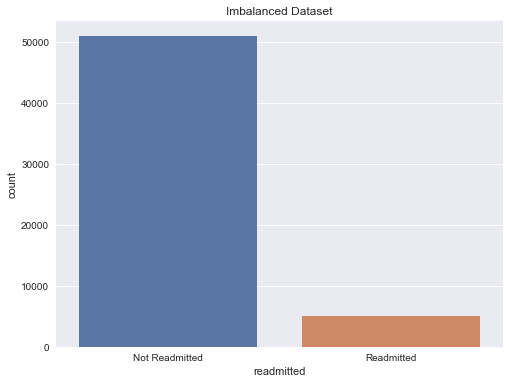

In [71]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='deep')
sns.despine()
plt.title('Imbalanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

In [72]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=123)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

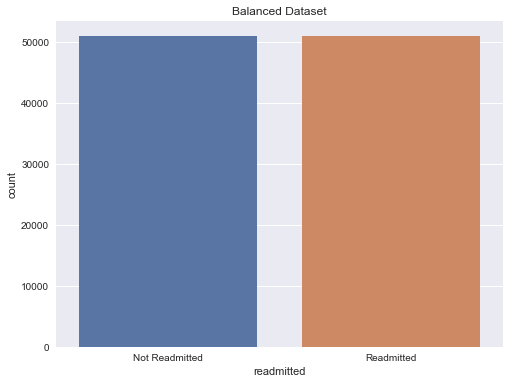

In [73]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_res, palette='deep')
sns.despine()
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

## Model Base Line

In [85]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [76]:
thresh = 0.5

## Logistic regression

In [78]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 123)
lr.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [86]:
y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.660
accuracy:0.910
recall:0.006
precision:0.508
specificity:0.999
prevalence:0.090
 
Test:
AUC:0.584
accuracy:0.367
recall:0.761
precision:0.100
specificity:0.328
prevalence:0.090
 
